# Tarea semanal 9
## Martín Deleón

### Consignas:

En esta tarea semanal llevaremos a la práctica todos los conceptos vistos sobre filtros digitales. Para esto realizaremos un laboratorio en donde buscamos eliminar las interferencias de una señal electrocardiográfica (ECG).
Dicha señal fue muestreada a 1KHz. Se pide que el filtro cumpla la siguiente plantilla:

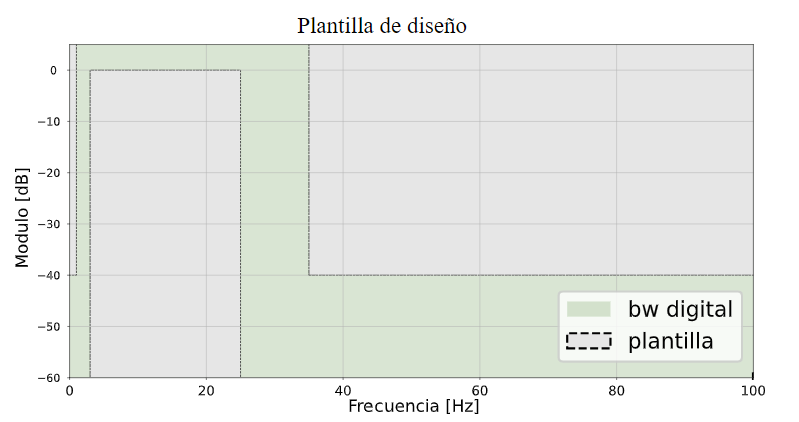

Para reañizar dicha tarea se diseñara un filtro IIR, de respuesta infita al impulso, y uno FIR, de respuesta finita al impulso.

### Parte 1
En esta sección diseñaremos los filtros para que cumplan con la plantilla requerida.

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla
from pytc2.sistemas_lineales import group_delay

In [2]:
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

In [3]:
# Plantilla

# filter design
AtMaxima = 1 # dB
AtMinima = 40 # dB

ws1 = 1.0 #Hz Atenuamos bajas frecuencias para filtrar ruido de pulmones por ejemplo
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

##### Filtro IIR
Para diseñar este filtro utilizaremos la función sig.iirdesign

In [4]:
frecs = np.array([1,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-AtMinima, -AtMinima, -AtMaxima, -AtMaxima, -AtMinima, -AtMinima])
gains = 10**(gains/20)

#iirdesign wp, ws, gpass, gstop, analog = false, ftype = 'ellip', output = sos, fs = none)
# gpas = perdida o atenuacion
#gstop = att minima en banda de stop

bp_sos_elipt = sig.iirdesign( wp=[wp1, wp2], ws=[ws1, ws2], gpass = AtMaxima, gstop=AtMinima, ftype= 'ellip', analog=False, output='sos', fs= fs)
print(bp_sos_elipt) # Coeficientes del filtro
w, h= sig.sosfreqz(sos= bp_sos_elipt, worN=2000, whole=False, fs = fs)
print("\n\"Orden del filtro:\" ", 2*bp_sos_elipt.shape[0])

[[ 0.00309834 -0.00599684  0.00309834  1.         -1.9451472   0.94803504]
 [ 1.          0.         -1.          1.         -1.93417486  0.95008226]
 [ 1.         -1.96445171  1.          1.         -1.96336537  0.98779905]
 [ 1.         -1.99986571  1.          1.         -1.9901988   0.99073365]
 [ 1.         -1.99975457  1.          1.         -1.99816401  0.99851962]]

"Orden del filtro:"  10


Cabe destacar las comillas en la linea impresa justo arriba de esta, dado que esta es una aproximación que puede o no coincidir con el orden del filtro. Esto se debe a que no sabemos si la la primer o última sección es lineal o no.

Una vez diseñado el filtro podemos ver su respuesta de modulo 

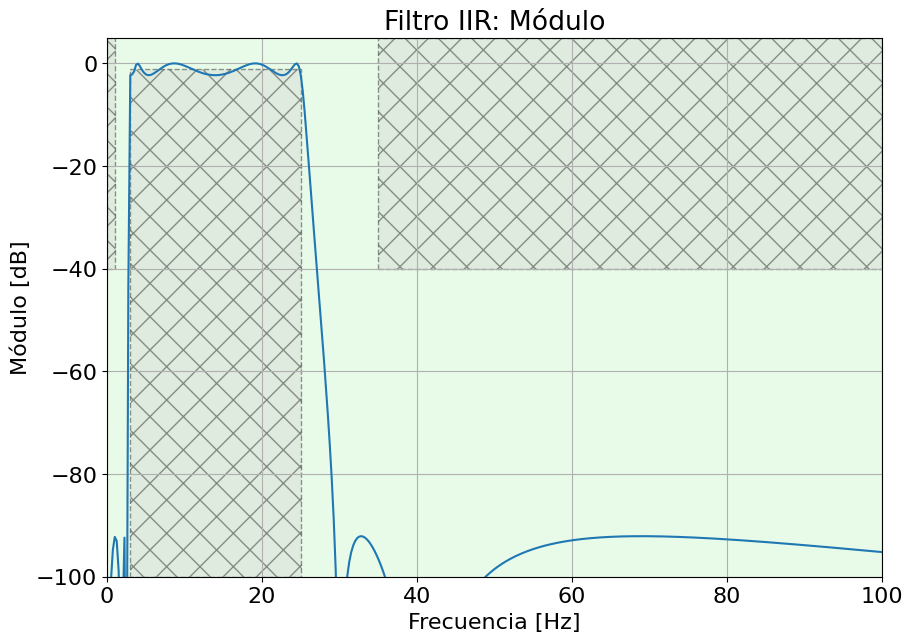

In [5]:
plt.figure(1)
plt.title("Filtro IIR: Módulo")
plt.ylabel('Módulo [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(visible=True)

plt.plot(w, 20*np.log(np.abs(h)));
plt.axis([0, 100, -100, 5 ])
plot_plantilla(filter_type= 'bandpass', fpass= frecs[[2, 3]]* nyq_frec, ripple= AtMaxima, fstop= frecs[[1, 4]]*nyq_frec, attenuation= AtMinima, fs= fs )

###### Respuesta de fase


(np.float64(0.0), np.float64(30.0), np.float64(-7.0), np.float64(7.0))

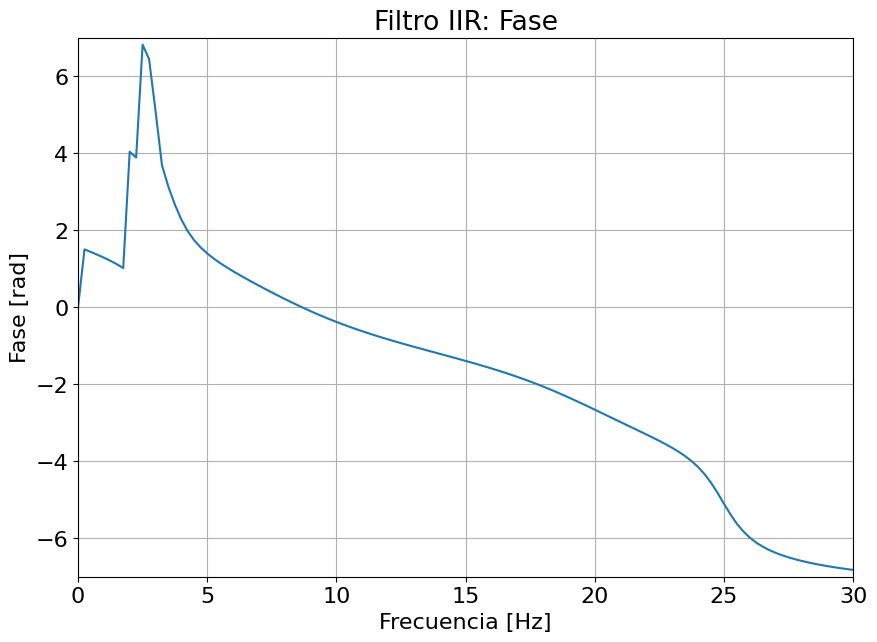

In [14]:

plt.figure(2)
plt.title("Filtro IIR: Fase")
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(visible=True)
plt.plot(w, np.unwrap(np.angle(h)));
plt.axis([0, 30, -7, 7 ])

###### Retardo de grupo

(np.float64(0.0), np.float64(50.0), np.float64(-20.0), np.float64(10.0))

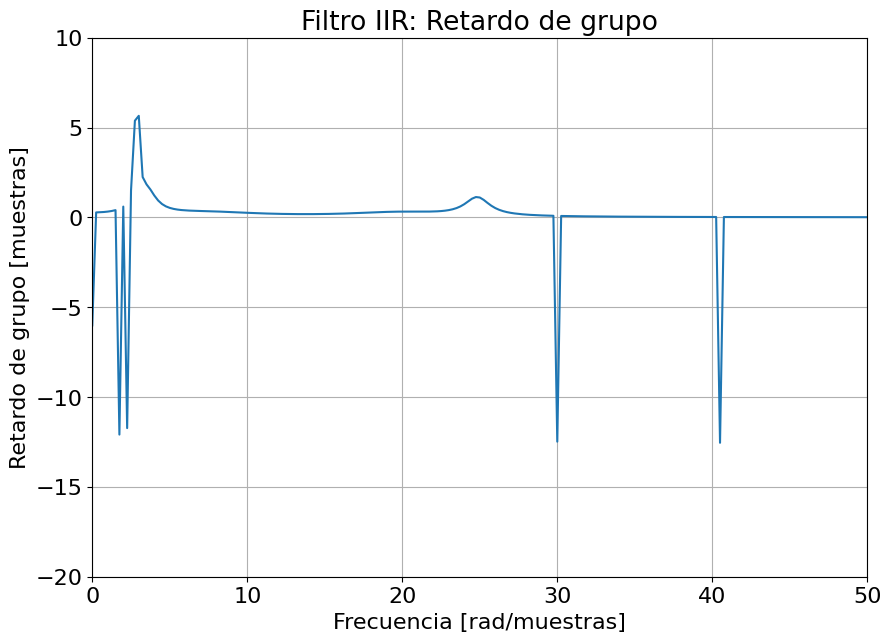

In [29]:
delta_w = np.diff(w)

gd = -np.diff(np.unwrap(np.angle(h)))/delta_w

#dif reduce en 1 el tamaño total, asi que le resto 1 a w
w_gd = w[:-1]

plt.figure(3)

plt.title('Filtro IIR: Retardo de grupo')
plt.plot(w_gd, gd)
plt.ylabel('Retardo de grupo [muestras]')
plt.xlabel('Frecuencia [rad/muestras]')
plt.grid()
plt.axis([0, 50, -20, 10 ])

En este punto, en una primer entrega no note el error de este retardo de grupo. El error esta porque no podemos utilizar las funciones del paquete signal dado que no sabemos como se comporta al tener ordenes mayores a 10. Para solucionar este problema recurrimos a la definición de retardo de grupo, es decir calcularemos el retardo de grupo a mano haciendo una derivada aproximada de la fase. Para esto hacemos la diferencia de dos muestras contiguas.
Para que queden mejor estos gráficos, primero los ploteamos por separado y luego ambos gráficos juntos para observar posibles diferencias.

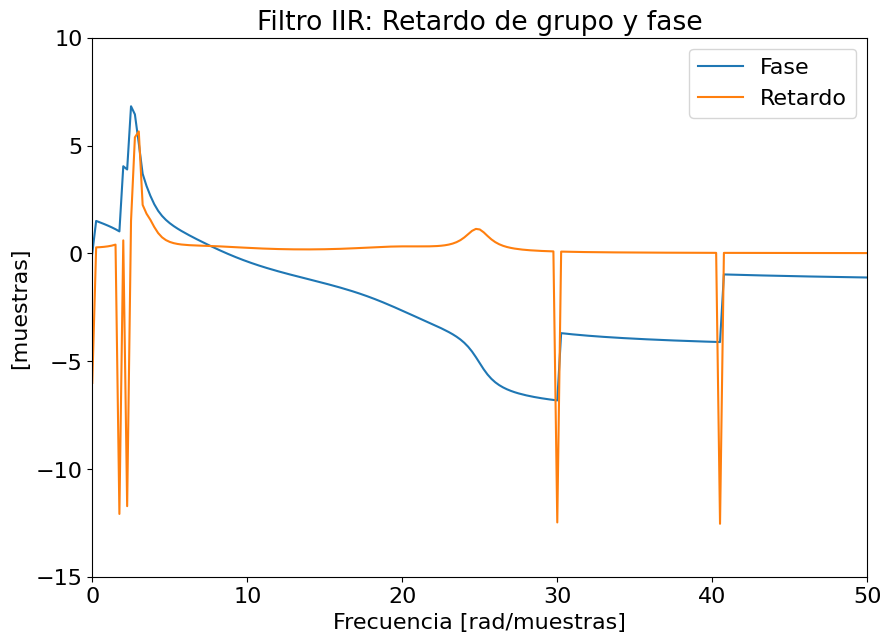

In [22]:
plt.title("Filtro IIR: Fase")
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(visible=True)
plt.plot(w, np.unwrap(np.angle(h)), label='Fase');

delta_w = np.diff(w)

gd = -np.diff(np.unwrap(np.angle(h)))/delta_w

#dif reduce en 1 el tamaño total, asi que le resto 1 a w
w_gd = w[:-1]

#plt.figure(3)

plt.title('Filtro IIR: Retardo de grupo y fase')
plt.plot(w_gd, gd, label='Retardo')
plt.ylabel('[muestras]')
plt.xlabel('Frecuencia [rad/muestras]')
plt.grid()
plt.axis([0, 50, -15, 10 ])
plt.legend()

###### Respuesta al impulso

Como la respuesta es pequeña en amplitud se amplifica poor 100 para que sea mas apreciable


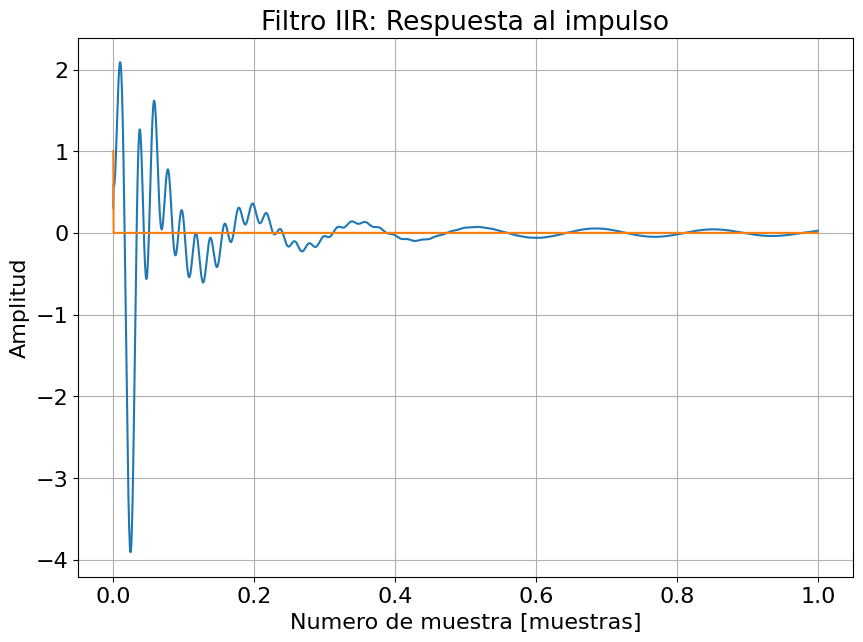

In [25]:
#### Respuesta al impulso del filtro IIR

imp = sig.unit_impulse(2000)
response = sig.sosfilt(bp_sos_elipt, imp)

plt.plot(np.linspace(0,1, 2000), response*100)
plt.plot(np.linspace(0,1, 2000), imp)

print("Como la respuesta es pequeña en amplitud se amplifica poor 100 para que sea mas apreciable")

plt.xlabel('Numero de muestra [muestras]')
plt.ylabel('Amplitud')
plt.title('Filtro IIR: Respuesta al impulso')

plt.grid(True)
plt.show()

En este punto se encuentra realizado todo lo que se pedia, por ende queda finalizado el diseño del filtro IIR, en la parte 2 de este Jupyter se utilizará este mismo filtro.

##### Filtro FIR
En esta sección realizaremos ek filtro FIR 

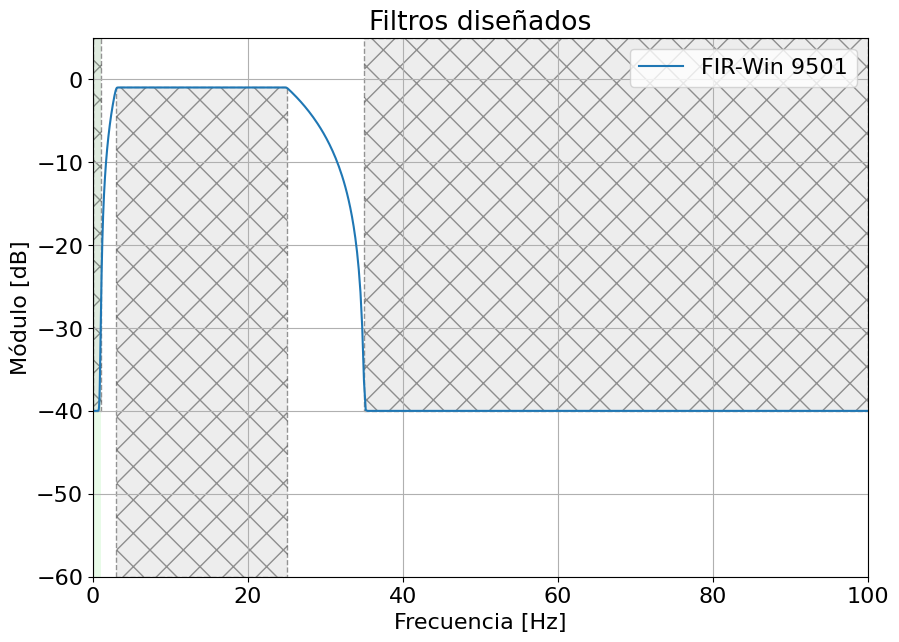

In [27]:
# Plantilla

# filter design
ripple = 1 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

cant_coeficientes = 9501

num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)

###### Respuesta de fase

(np.float64(0.0),
 np.float64(500.0),
 np.float64(-6.283185307179586),
 np.float64(6.283185307179586))

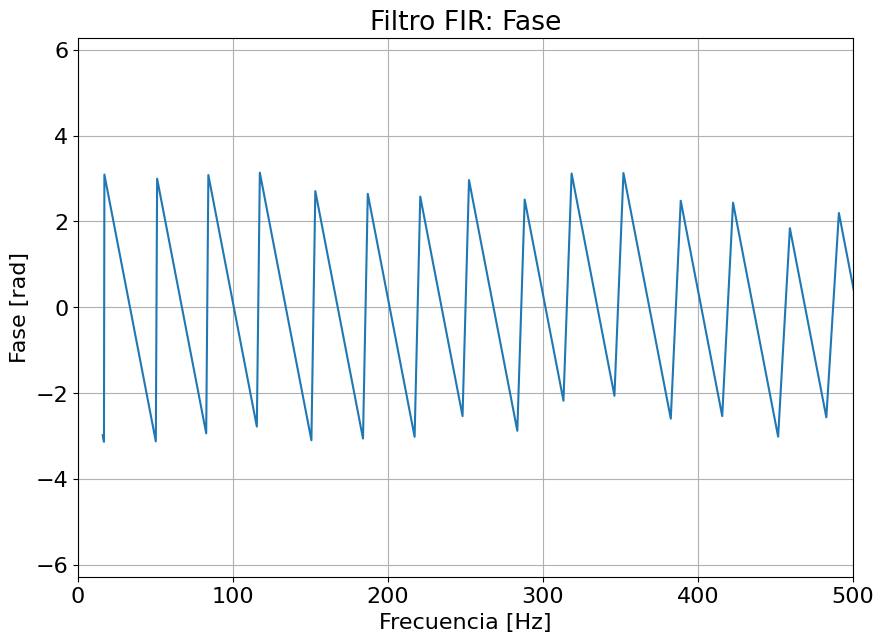

In [28]:
plt.figure(2)
phase=np.angle(hh_win)
plt.plot((w / np.pi * nyq_frec), phase)

plt.title('Filtro FIR: Fase')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, nyq_frec, -2*np.pi, 2*np.pi ])

###### Retardo de grupo

(np.float64(0.0), np.float64(500.0), np.float64(4500.0), np.float64(5000.0))

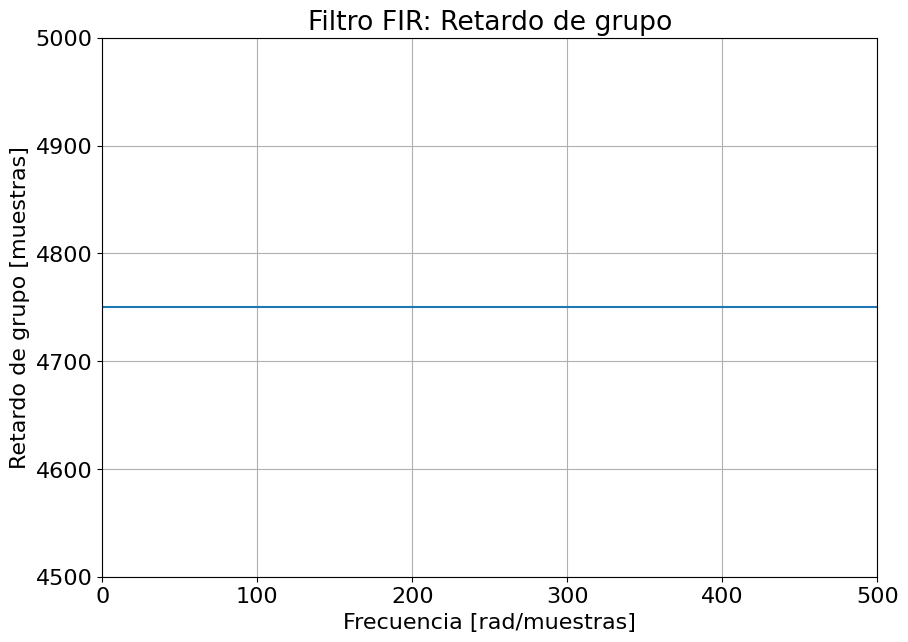

In [30]:
w, gd = sig.group_delay((num_win, den), w=1000, whole=False, fs=fs)

plt.title('Filtro FIR: Retardo de grupo')
plt.plot(w, gd)
plt.ylabel('Retardo de grupo [muestras]')
plt.xlabel('Frecuencia [rad/muestras]')
plt.grid()
plt.axis([0, nyq_frec, 4500, 5000])

###### Respuesta al impulso

Como la respuesta es pequeña en amplitud se amplifica poor 100 para que sea mas apreciable


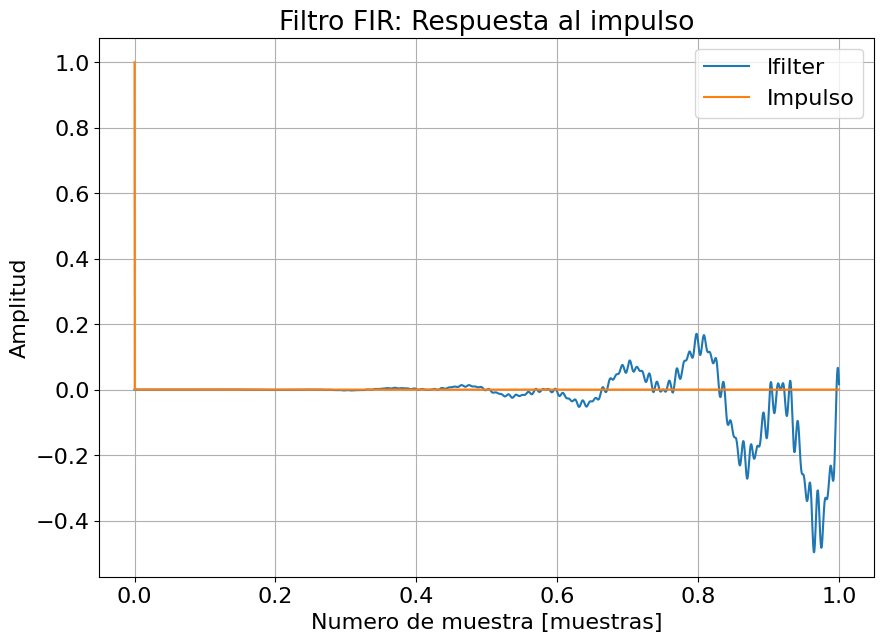

In [70]:
imp = sig.unit_impulse(3000)

den=np.zeros(5001)
den[0]=1

respuesta = sig.lfilter(num_win, den, imp)


print("Como la respuesta es pequeña en amplitud se amplifica poor 100 para que sea mas apreciable")
plt.plot(np.linspace(0,1, 3000), respuesta*100000, label='lfilter')
plt.plot(np.linspace(0,1, 3000), imp, label='Impulso')

plt.legend()
plt.xlabel('Numero de muestra [muestras]')
plt.ylabel('Amplitud')
plt.title('Filtro FIR: Respuesta al impulso')

plt.grid(True)
plt.show()

En este punto podemos ver que el resultado obtenido es incorrecto, esto tambien se debe a que se utilizo la función lfilter que no sirve para esto. En el siguiente gráfico se muestra la respuesta correcta.

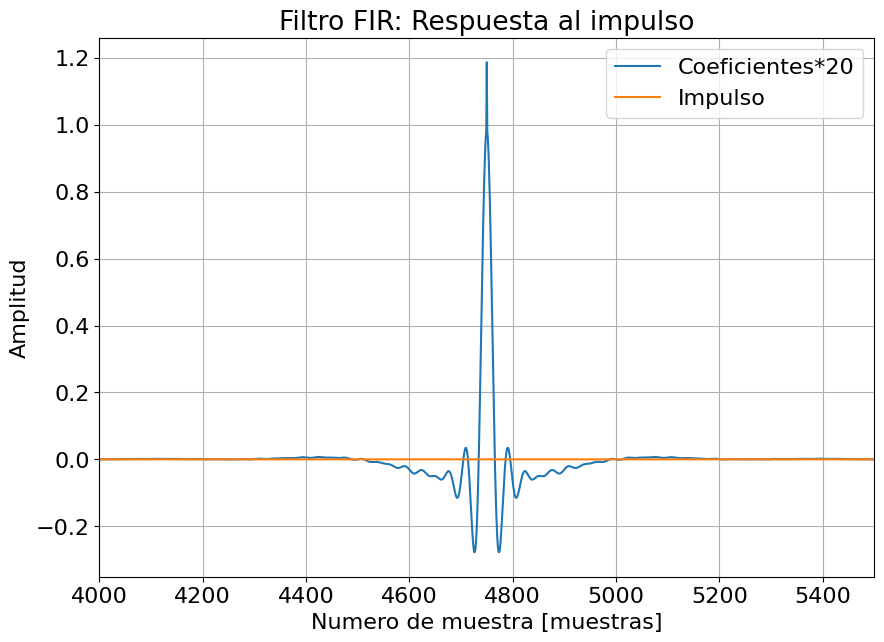

In [72]:
imp = sig.unit_impulse(9501)
plt.xlim(4000, 5500)
plt.legend()
plt.plot(np.linspace(0,9500, 9501), num_win*20, label='Coeficientes*20')
plt.plot(np.linspace(0,9500, 9501), imp, label='Impulso')
plt.legend()
plt.xlabel('Numero de muestra [muestras]')
plt.ylabel('Amplitud')
plt.title('Filtro FIR: Respuesta al impulso')
plt.grid(True)
plt.show()


En este punto se cumplieron todos los requisitos de deiseño, por lo que se da por concluida esta sección. Es destacable como era de esperar que los gráficos de fase y retardo de grupo son bastante buenos en este tipo de filtros. Por esta razón se eligió un orden impar de filtro, de esta forma la el retardo da un número entero de muestras y fase lineal.

###### Diseño de FIR utilizando FIRLS

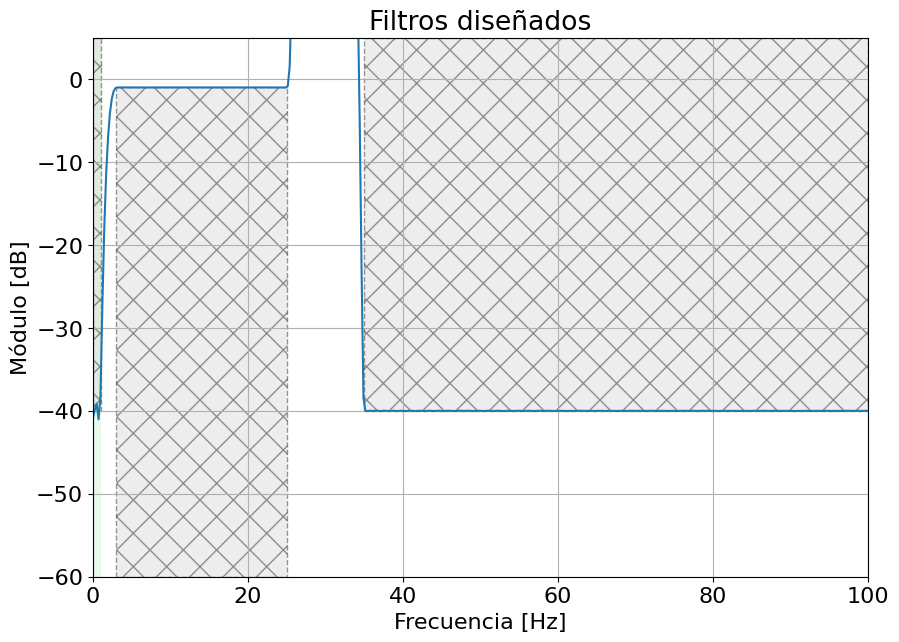

In [105]:
# Usando  FIRLS

fir_firls = sig.firls(1501, bands=frecs, desired= gains, fs=None)   #Devueleve los coeficientes del filtro
w, h = sig.freqz(fir_firls, a = 1, worN= 2048, whole= False, fs= fs)
plt.plot(w, 20 * np.log10(abs(h)), label='FIR-Win {:d}'.format(num_win.shape[0]))
plt.plot()
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)


##### Parte 2
Filtrado de la señal:

Una vez diseñados los filtros procederemos a utilizarlos. Para ello SciPy dispone de implementraciones de las ecuaciones de diferencias, la tradicional, utilizando lfilter y la variante por SOS's mediante sosfilt. La primera puede usarse para filtros FIR de cualquier tamaño, e IIR de bajo orden (<= 3 secciones u orden 6), mientras que la segunda es obligatoria para filtros IIR de orden superior.

In [106]:
# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
den = 1
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)


Ahora visualizamos los resultados, para ello se cuenta con diferentes regiones de interés (ROI's) para poder evaluar qué tan bien se comportan los filtros diseñados. Primero revisaremos zonas de alta contaminación para evaluar qué tan eficiente es el filtrado.

Recordar que cada filtro impone una demora a la señal filtrada, por lo tanto, dicha demora puede corregirse para cada filtro retrasando la señal de entrada o adelantando la señal de salida. Recuerde que como la señal ya fue registrada, una secuencia puede adelantarse.

Demora = 4750


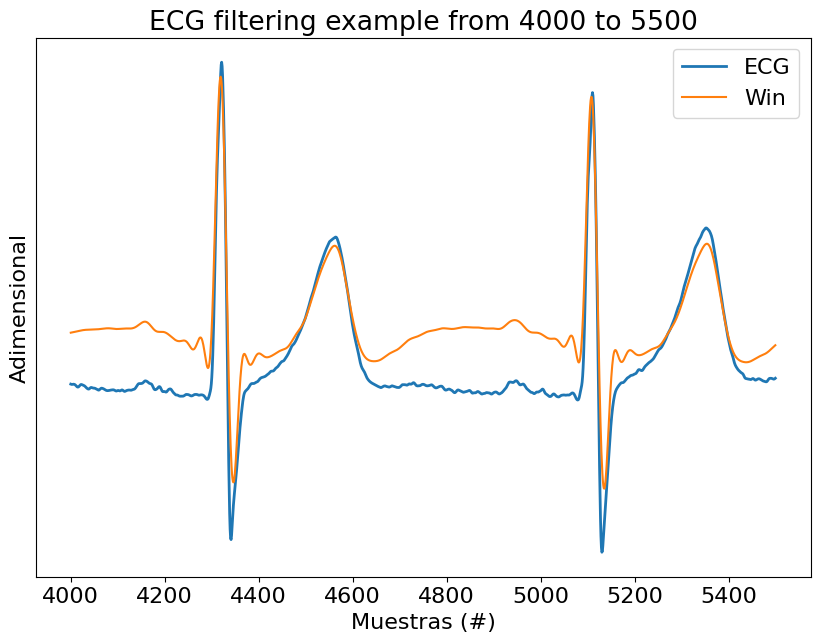

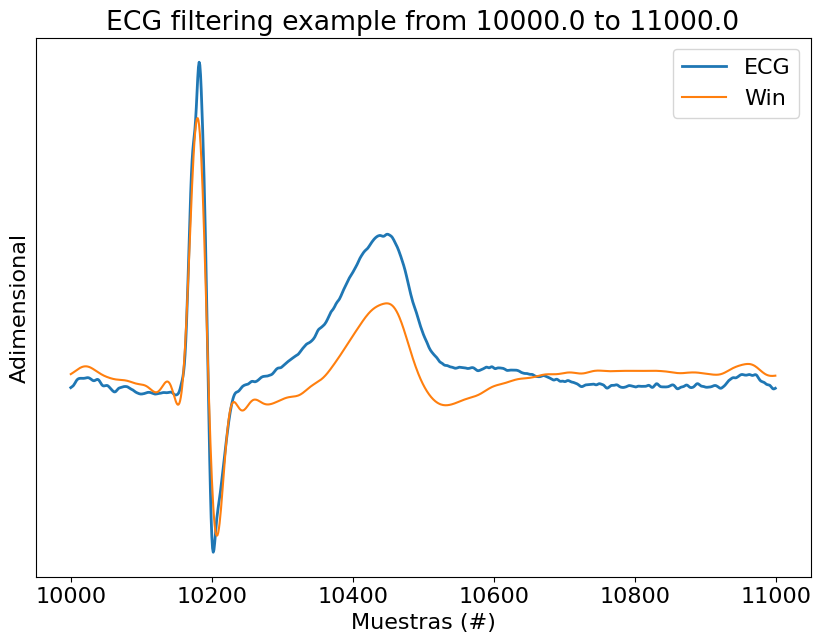

In [107]:
#Se calcula el retardo del filtro para sincronizar la señal de entrada y salida

w, gd = sig.group_delay((num_win, den), w=2000, whole=False, fs=fs)
demora=int(np.round(gd[250]))

print("Demora =",demora)
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

En este punto deberiamos ver que la demora calculada corrije el la señal y tendríamos que ver las dos señales solapadas, sin embargo no logro hacer que esto suceda. No pudo explicar este comportamiento, según lo visto teoricamente, el código que corrije esto esta bien implementado.

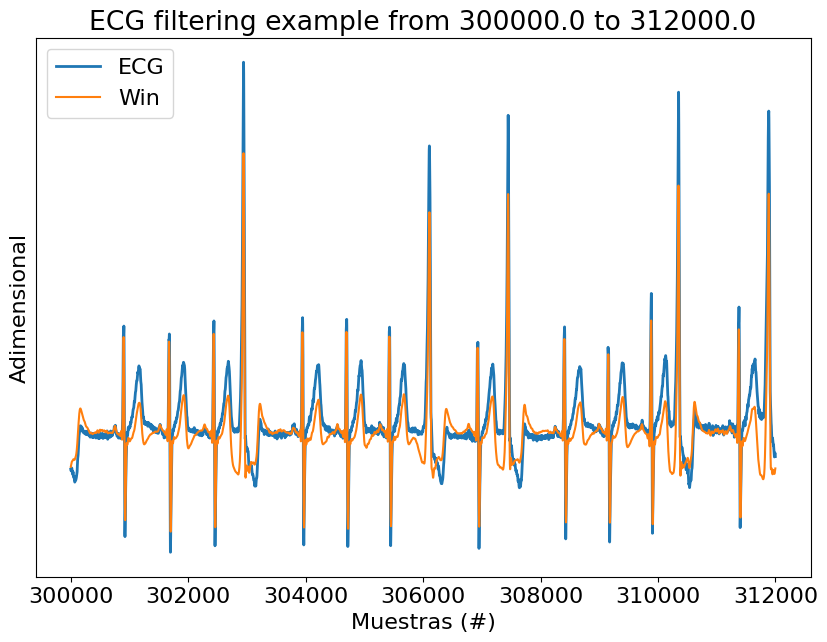

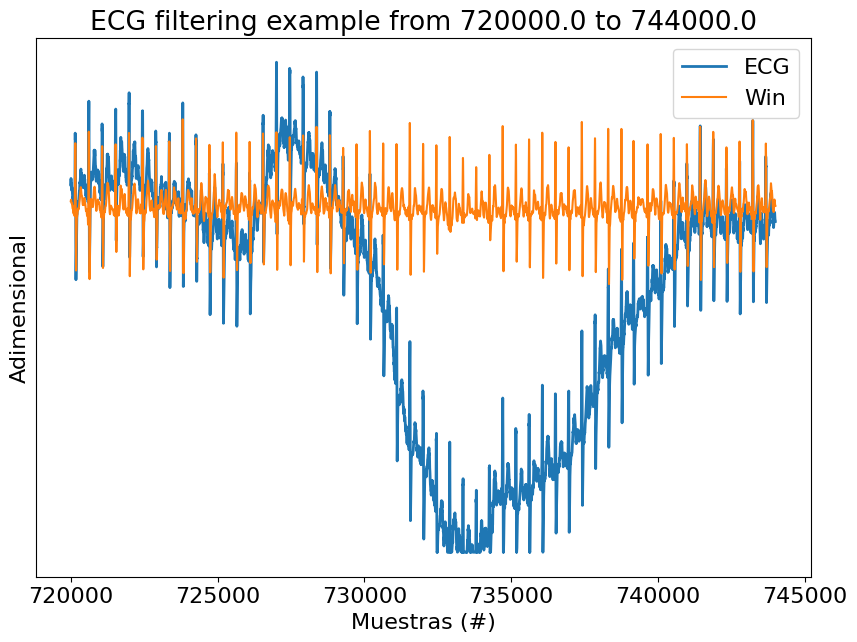

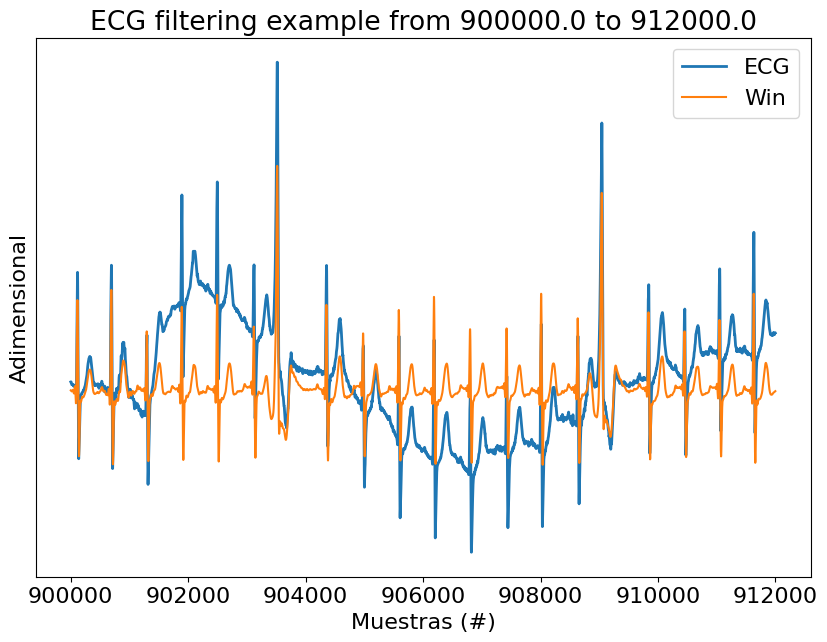

In [108]:
# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Dicha contaminación probablemente se deba al aumento de la actividad física durante la prueba de esfuerzo. Como se observa, la mayor parte de las técnicas de filtrados es inocua cuando no hay contaminación de baja frecuencia, y remueve los movimientos de la línea de base correctamente.

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos con baja contaminación, es decir qué tan inocuo es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico.

##### Extra
Por último se investigó un poco más sobre el procesamiento de este tipo de señales y se diseñó un filtro más especifico para esta aplicación. Sin embargo dado que el tiempo es finito, no se procederá a hacer todo el desarrollo anterior.

#### Filtro FIR

Para el filtro FIR, el método de ventana resulta ser el mejor. Este consta de multiplicar la respuesta del brick wall contra una ventana que tendrá una forma especifica para que el resultado genere el h[n] finito. Además para que el filtro sea causal, el filtro debe estar desplazado.
En este caso dado que la señal viene de un ECG, la ventana a utilizar es la llamada "Kaiser". Esta ventana tiene una fórmula temporal algo compleja, pero Python nos aliviará este trabajo.

\begin {equation}
   w[n] = \frac{I_0\left(\beta \sqrt{1 - \left( \frac{2n}{N-1} - 1 \right)^2}\right)}{I_0(\beta)}
\end {equation}

\begin {equation}
    w[n] = \frac{I_0(\beta\sqrt{1-(\frac{2n}{N-1}-1)^2})}{I_0(\beta)}
\end {equation}
Dejo las dos ecuaciones que si bien son la misma, a mi en el jupyter no me falla pero en el nbviewer si.

Al momento de implementar en Python, la librería del Scipy pide el parámetro beta. Este parámetro lo que hace es afectar la forma y característica de la vaenta. Para obtener la mejor respuesta posible hay que iterar y hacer una inspección visual de como queda la respuesta.

##### Respuesta de modulo

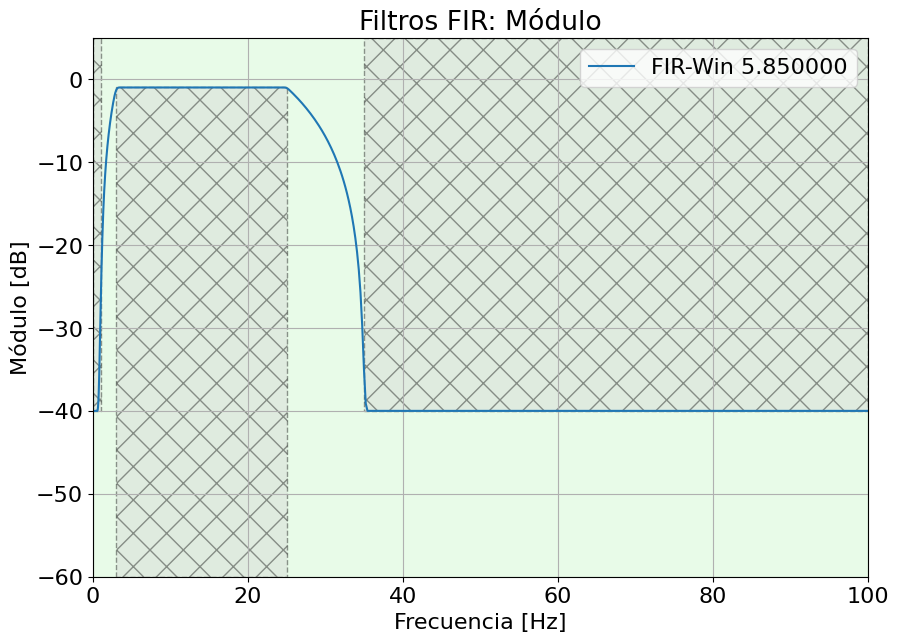

In [109]:
# Diseño del filtro FIR
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-AtMinima, -AtMinima, -AtMaxima, -AtMaxima, -AtMinima, -AtMinima])
gains = 10**(gains/20)

cantCoeficientes = 4001 
#Defino Cantidad de coeficientes impares para que el orden quede par

beta = 5.85
num_win = sig.firwin2(cantCoeficientes, frecs, gains , window= ('kaiser', beta))

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:f}'.format(beta))

plt.title('Filtros FIR: Módulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = AtMaxima , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = AtMinima, fs = fs)

##### Respuesta de fase

(np.float64(0.0),
 np.float64(500.0),
 np.float64(-6.283185307179586),
 np.float64(6.283185307179586))

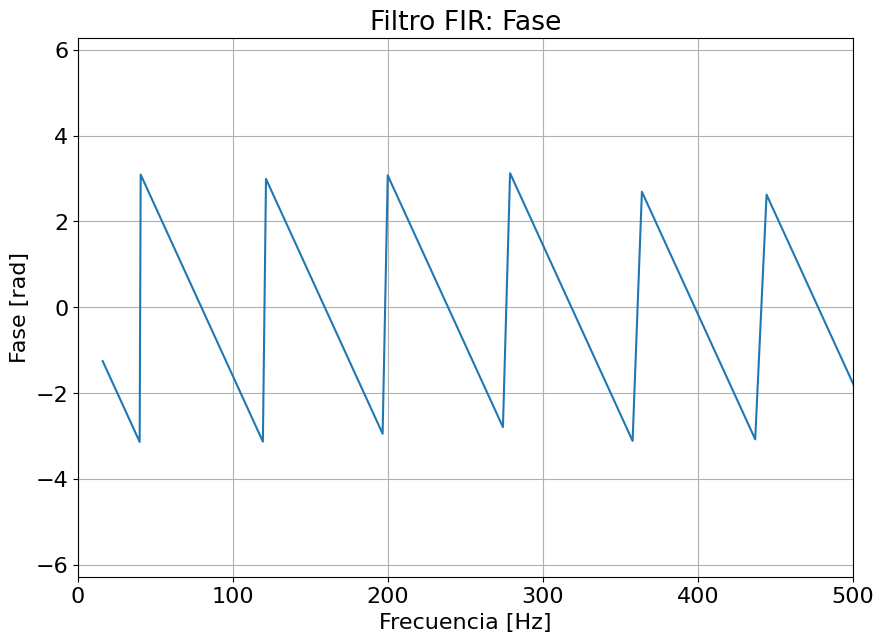

In [110]:
plt.figure(2)
phase=np.angle(hh_win)
plt.plot((w / np.pi * nyq_frec), phase)

plt.title('Filtro FIR: Fase')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, nyq_frec, -2*np.pi, 2*np.pi ])

##### Retardo de grupo

(np.float64(0.0), np.float64(500.0), np.float64(1000.0), np.float64(3000.0))

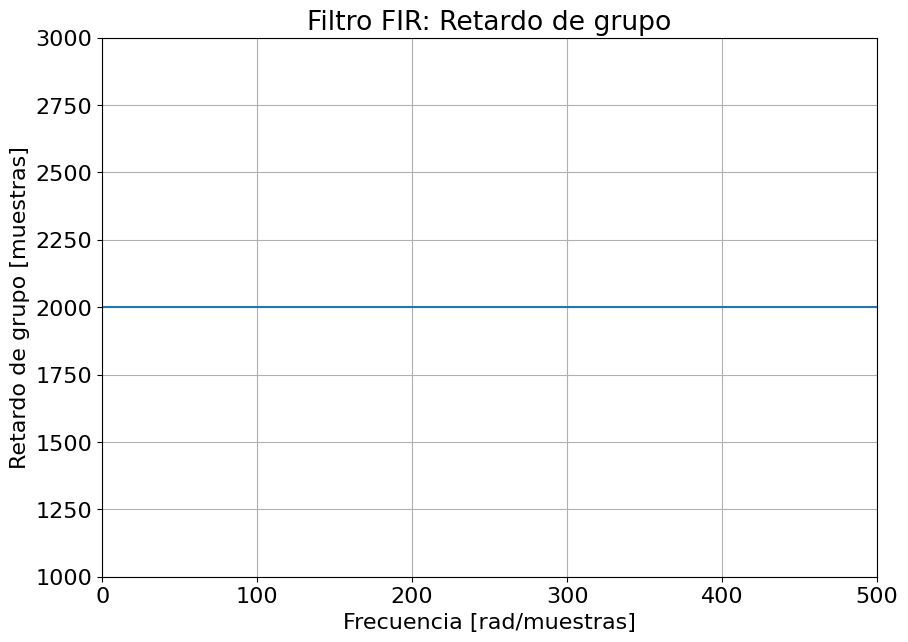

: 

In [111]:
w, gd = sig.group_delay((num_win, den), w=1000, whole=False, fs=fs)

plt.title('Filtro FIR: Retardo de grupo')
plt.plot(w, gd)
plt.ylabel('Retardo de grupo [muestras]')
plt.xlabel('Frecuencia [rad/muestras]')
plt.grid()
plt.axis([0, nyq_frec, 1000, 3000])

#### Preguntas del Jupyter
Quedan pendiente las siguientes cuestiones, en caso que los filtros no se hayan comportado de acuerdo a lo esperado:

   1. ¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?
   2. ¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?

  1.  El filtro fue eficiente a la hora de eliminar las frecuencias interferentes en las zonas de alta contaminación, es evidente como la señal se mantiene bastante bien filtrando las evidentes frecuencias que dificultan entender la misma.
  2.  Los dañan las zonas de la señal donde la contaminación el filtro deforma la señal aunque esto no sea lo esperado, es probable que la plantilla no sea la mejor para esta señal, ya que evidentemente esta atenuando frecuencias que traen información. Otra de las causas de los problemas del filtro puede ser que la relación señal a ruido de la señal no sea buena por lo que se esta mezclando ambas cosas en la salida.
  
Con un par de ajustes en la plantilla inicial se puede llegar a conseguir un filtro que funciones de manera óptima para esta señal, el filtro conseguido en esta práctica de laboratorio esta muy cercano a lo esperado, el único problema es la deformación en las zonas de baja contaminación, lo que lleva a pensar que las frecuencias de corte y paso de la plantilla no estan del todo bien definidas. Modificando estos valores se podría conseguir que estas frecuencias que contienen información importante para la interpretación de la señal